In [1]:
# 各自のGoogleDriveマウント
#from google.colab import drive
#drive.mount('/content/drive')

import numpy as np
import pandas as pd
import glob
from PIL import Image
import matplotlib.pyplot as plt
import cv2  #OpenCVのインポート
from pathlib import Path
import datetime
import os
%matplotlib inline

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout, Activation, Flatten
from tensorflow.keras.layers import Reshape, Embedding, InputLayer
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [43]:
#メインパス
#path = '/content/drive/MyDrive/signate_practice_chuzo/'
path = './'

# if 1で実行したらif 0に戻す
if 0:
#正常データのみを学習する
    
    img_list = glob.glob(path + 'train/ok/*' + ".jpeg")
    #print(img_list)
    train_data = np.empty((0,300,300,3))
    for img in img_list:
        img_ = Image.open(img)
        img = np.array(img_)
        img = img / 255.
        img = img.reshape((1,300,300,3))
        #img = img[:, 340:660, 57:953, :]
        train_data = np.concatenate([train_data, img], axis = 0)
        #print(train_data.shape)
    np.save(path + 'train_data.npy', train_data)

#NG画像    
    img_list = glob.glob(path + 'train/def/*' + ".jpeg")
    error_data = np.empty((0,300,300,3))
    for img in img_list:
        img_ = Image.open(img)
        img = np.array(img_)
        img = img / 255.
        img = img.reshape((1,300,300,3))
        #img = img[:, 340:660, 57:953, :]
        error_data = np.concatenate([error_data, img], axis = 0)
    np.save(path + 'error_data.npy', error_data) 

#お試し用に10枚（予め正常Trainから切り取り貼り付けしておく）
    
#    img_list = glob.glob(path + 'train/ok/*' + ".jpeg")
#    good_data = np.empty((0,300,300,3))
#    for img in img_list:
#        img_ = Image.open(img)
#        img = np.array(img_)
#        img = img / 255.
#        img = img.reshape((1,300,300,3))
#        #img = img[:, 340:660, 57:953, :]
#     good_data = np.concatenate([good_data, img], axis = 0)
#np.save(path + 'good_data.npy', good_data)     

In [44]:
# 先ほど↑でndarrayにしておいたTrain,Validデータを読み込む
train_data = np.load(path + 'train_data.npy')
error_data = np.load(path + 'error_data.npy')
#good_data = np.load(path + 'good_data.npy')
print("train_data.shape", train_data.shape)
print("error_data.shape", error_data.shape)
#print("good_data.shape", good_data.shape)

train_data.shape (100, 300, 300, 3)
error_data.shape (150, 300, 300, 3)


In [4]:
# CNNVAEモデルの定義

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# 入力サイズ
input_shape = (300, 300, 3)

# 潜在空間の次元を決める
latent_dim = 20

K.clear_session()

# VAE model = encoder + decoder
# encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), (2, 2), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (2, 2), (2, 2), activation='relu', padding='same')(x)
shape = K.int_shape(x)
print("shape[1], shape[2], shape[3]",shape[1], shape[2], shape[3])
x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (3, 3), (2, 2), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), (2, 2), activation='relu', padding='same')(x)
outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# 再構成誤差はバイナリクロスエントロピー
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))

# 再構成誤差にこの係数を掛け算しないと何故だか上手く行かなかった。
reconstruction_loss *= 300*300

# KLダイバージェンスを計算する
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# 再構成誤差とKLダイバージェンスの和がVAEのLOSS
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# 評価値の改善が止まった時に学習率を減らす
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.5,
                            patience=40,
                            min_lr=0.0001
                            )
#best weight save
saved_model_name = 'vae_z20_trans'
mc = ModelCheckpoint(f'best_{saved_model_name}_weight.h5',
                     monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#EarlyStop
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')

shape[1], shape[2], shape[3] 75 75 64
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 300, 300, 32) 896         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 300, 300, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 150, 150, 32) 9248        conv2d_1[0][0]                   
______________________________________________________

In [5]:
# if 1で学習したらif 0に戻す
if 0:
    # 学習
    #vae.load_weights(path + "best_vae_z40_weight.h5")
    hist = vae.fit(train_data,
                epochs=300,
                batch_size=10,
                validation_data=(train_data, None),
                callbacks=[reduce_lr,mc,es],
                )
    # model save
    vae.save(path + 'vae_z20_trans.h5', include_optimizer=False)

In [55]:
#model = keras.models.load_model(path + 'vae_z20.h5', compile=False)
model = vae
model.load_weights(path + "best_vae_z20_trans_weight.h5")
model.summary()


Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 20), (None,  14491304    encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 300, 300, 3)  7708611     encoder[0][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 300, 300, 32) 896         encoder_input[0][0]              
____________________________________________________________________________________________

ok_data.shape (100, 300, 300, 3)


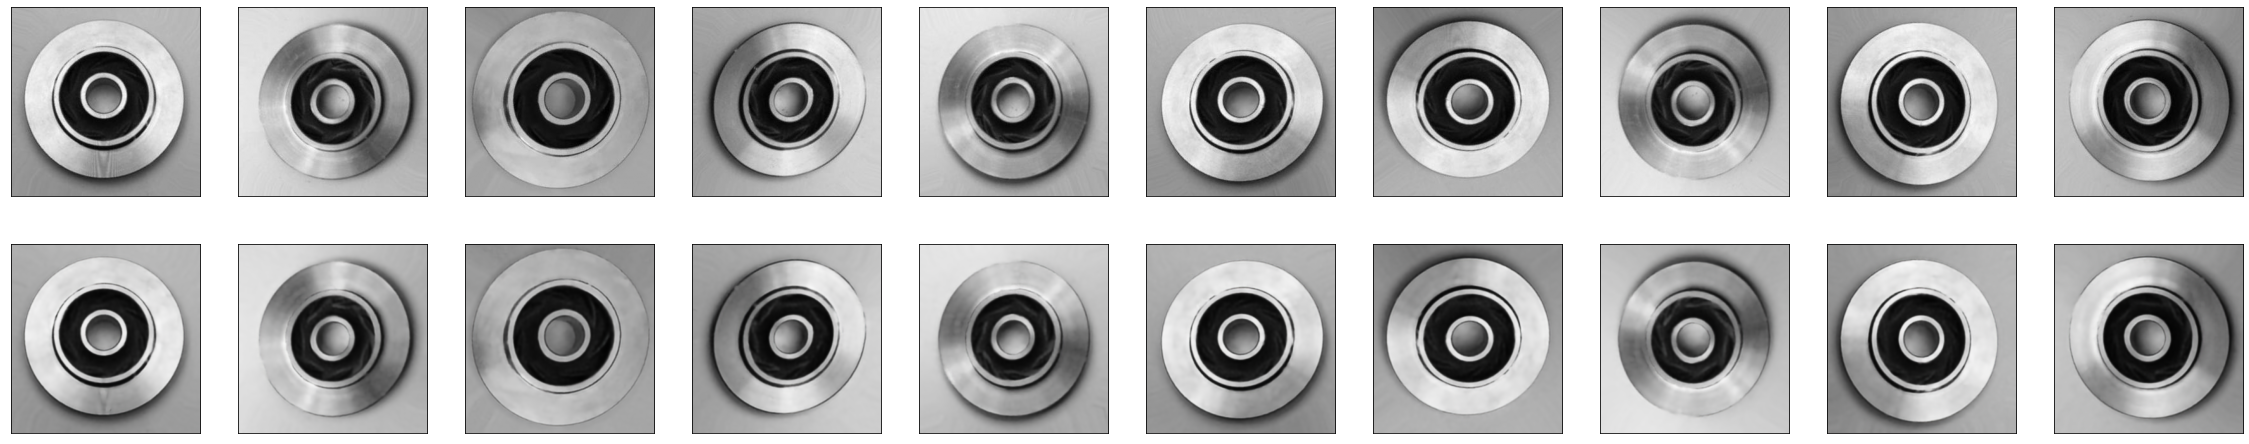

In [7]:
ok_data = model.predict(train_data)
print("ok_data.shape",ok_data.shape)

n = 10
plt.figure(figsize=(40, 8))
for i in range(n):
    # テスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(train_data[i].reshape(300, 300, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(ok_data[i].reshape(300, 300, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

ng_data.shape (150, 300, 300, 3)


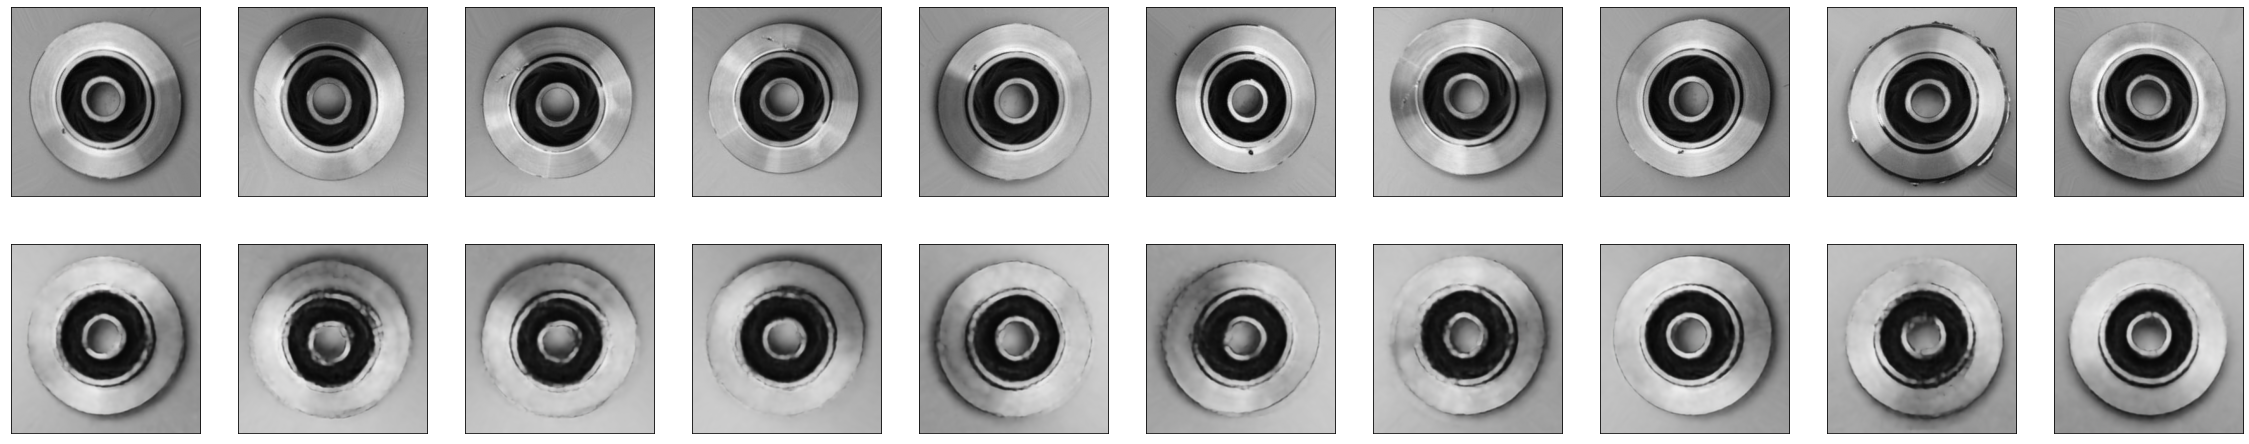

In [8]:
ng_data = model.predict(error_data)
print("ng_data.shape",ng_data.shape)

n = 10
plt.figure(figsize=(40, 8))
for i in range(n):
    # テスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(error_data[i].reshape(300, 300, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(ng_data[i].reshape(300, 300, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

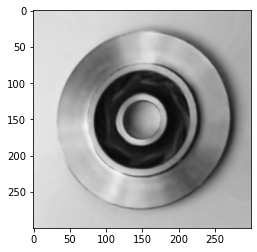

In [9]:
plt.imshow(np.float32(ok_data[1]))


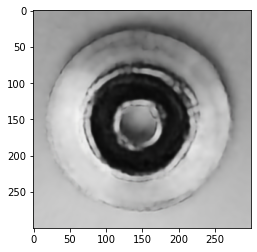

In [10]:
plt.imshow(np.float32(ng_data[1]))

In [14]:
#画像を２値化
def binary_image(image,th):
    '''
    image 入力画像(numpy)
    th    0/1判定閾値(0~1)
    '''
    binary_image = np.empty((300,300,3))
    for c in range(3):
        for h in range(300):
            for v in range(300):
                pixel = image[h,v,c]
                if pixel <= th:
                     pixel = 0
                else:
                     pixel = 1
                binary_image[h,v,c] = pixel
    return binary_image

In [18]:
train_data_test = binary_image(train_data[1],0.5)

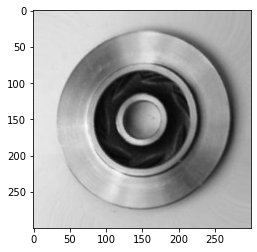

In [19]:
plt.imshow(np.float32(train_data[1]))


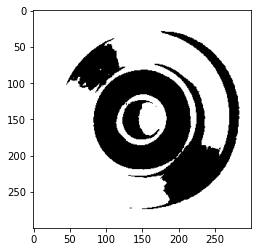

In [20]:
plt.imshow(np.float32(train_data_test))

good max 0.4466379523812353
bad min 0.9064156756788059


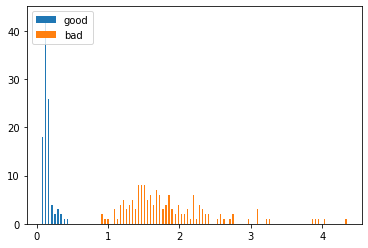

In [21]:
# 入力した画像とVAEが生成した画像の差分を計算する
#print("good")
good_loss = []

for i in range(100):
    #２値化
    train_data_bi = binary_image(train_data[i],0.5)
    ok_data_bi    = binary_image(ok_data[i],0.5)
    #再構成誤差
    reconstruction_loss = binary_crossentropy(K.flatten(train_data_bi), K.flatten(ok_data_bi))
    reconstruction_loss = reconstruction_loss.numpy()
    #print(reconstruction_loss)
    good_loss.append(reconstruction_loss)

# NG画像
#print("bad")
bad_loss =[]
ng = 0

for i in range(150):
    #２値化
    error_data_bi = binary_image(error_data[i],0.5)
    ng_data_bi = binary_image(ng_data[i],0.5)
    #再構成誤差
    reconstruction_loss = binary_crossentropy(K.flatten(error_data_bi), K.flatten(ng_data_bi))
    reconstruction_loss = reconstruction_loss.numpy()
    #print(reconstruction_loss)
    bad_loss.append(reconstruction_loss)

print("good max",max(good_loss))
print("bad min" ,min(bad_loss))

plt.hist([good_loss,bad_loss], bins = 100, label=["good", "bad"])
plt.legend(loc='upper right')
plt.show()

In [22]:
# 入力した画像とVAEが生成した画像の差分を計算する

# OK画像
ok =0

for i in range(100):
    #２値化
    train_data_bi = binary_image(train_data[i],0.5)
    ok_data_bi    = binary_image(ok_data[i],0.5)
    #再構成誤差
    reconstruction_loss = binary_crossentropy(K.flatten(train_data_bi), K.flatten(ok_data_bi))
    
    if reconstruction_loss <= 0.5: #閾値
        f_ok = 1
    else:
        f_ok = 0 
    #print("f_ok=", f_ok)

    ok += f_ok 

print("OK検出率=", ok/100)
print("\n")

# NG画像

ng = 0
for i in range(150):
    #２値化
    error_data_bi = binary_image(error_data[i],0.5)
    ng_data_bi = binary_image(ng_data[i],0.5)
    #再構成誤差
    reconstruction_loss = binary_crossentropy(K.flatten(error_data_bi), K.flatten(ng_data_bi))
    if reconstruction_loss > 0.5: #閾値
        f_ng = 1
    else:
        f_ng = 0 
    #print("f_ng=", f_ng)

    ng += f_ng 

print("NG検出率=", ng/150)
print("\n")

OK検出率= 1.0


NG検出率= 1.0




In [56]:
# SIGNATEテスト画像読み込み
path_input = path + "input/"
_test_images_path = os.path.join(path_input,'test_data')

test_list=pd.read_csv(path +'sample_submission.csv', header=None)
print(test_list.head())

test_data = np.empty((0,300,300,3))

for _, row in test_list.iterrows():
    img_ = Image.open(os.path.join(_test_images_path , row[0]))
    img  = np.array(img_)
    img  = img / 255.
    img = img.reshape((1,300,300,3))
    #img = img[:, 340:660, 57:953, :]
    test_data = np.concatenate([test_data, img], axis = 0)
np.save(path + 'test_data.npy', test_data) 

test_data = np.load(path +'test_data.npy')
print("test_data.shape", test_data.shape)


            0  1
0  19871.jpeg  0
1  29934.jpeg  0
2  39826.jpeg  0
3  49888.jpeg  0
4  59918.jpeg  0
test_data.shape (100, 300, 300, 3)


test_pred.shape (100, 300, 300, 3)


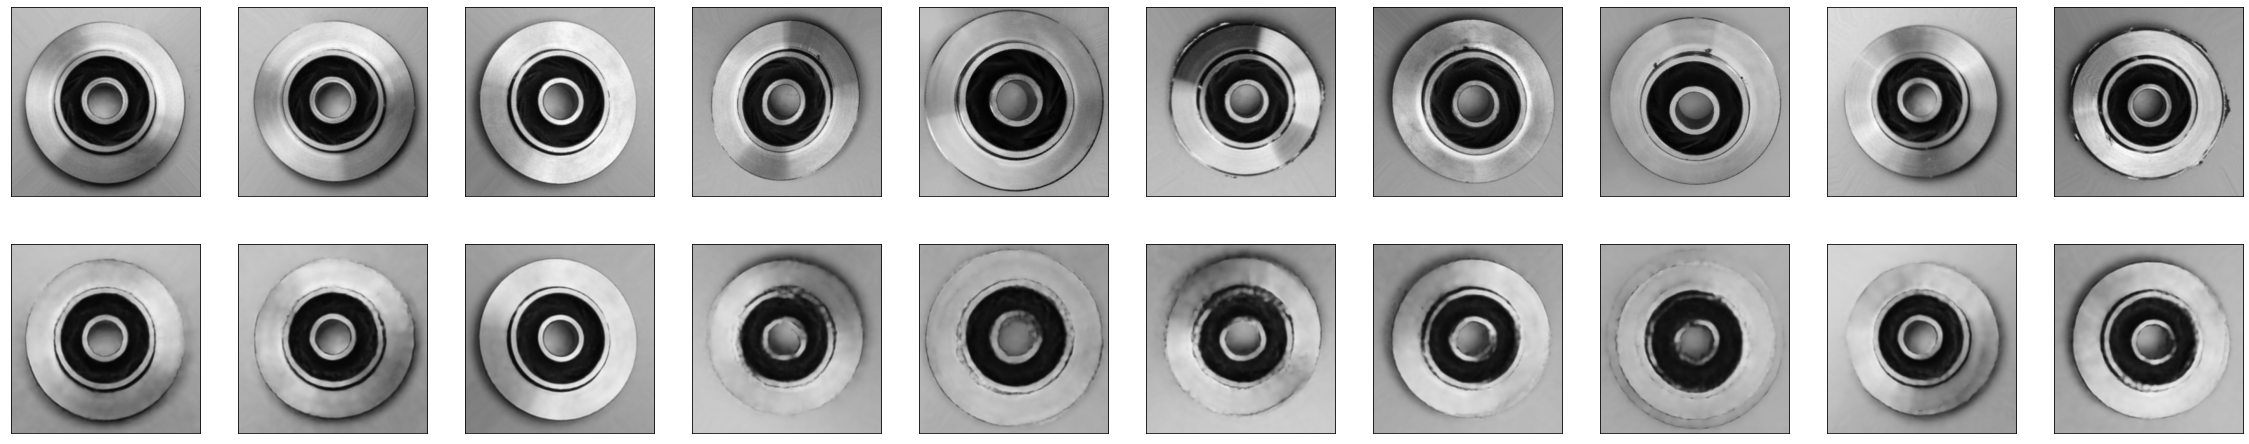

In [57]:
test_pred = model.predict(test_data)
print("test_pred.shape",test_pred.shape)

n = 10
plt.figure(figsize=(40, 8))
for i in range(n):
    # テスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_data[i].reshape(300, 300, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(test_pred[i].reshape(300, 300, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

pred_sub_data.shape (100, 300, 300, 3)


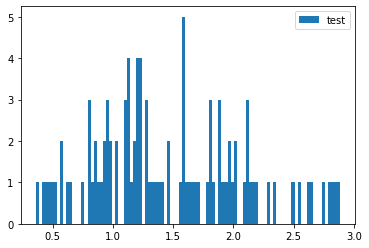

In [62]:
# SIGNATEテスト画像

pred_sub_data = model.predict(test_data)
print("pred_sub_data.shape",pred_sub_data.shape)

ok =0
test_loss = []
for i in range(100):
    #２値化
    test_data_bi     = binary_image(test_data[i],0.5)
    pred_sub_data_bi = binary_image(pred_sub_data[i],0.5)
    #再構成誤差
    reconstruction_loss = binary_crossentropy(K.flatten(test_data_bi), K.flatten(pred_sub_data_bi))
    reconstruction_loss = reconstruction_loss.numpy()
    #print(reconstruction_loss)
    test_loss.append(reconstruction_loss)
    
    
#print("test max",max(test_loss))
#print("test min" ,min(test_loss))

plt.hist(test_loss, bins = 100, label=["test"])
plt.legend(loc='upper right')
plt.show()

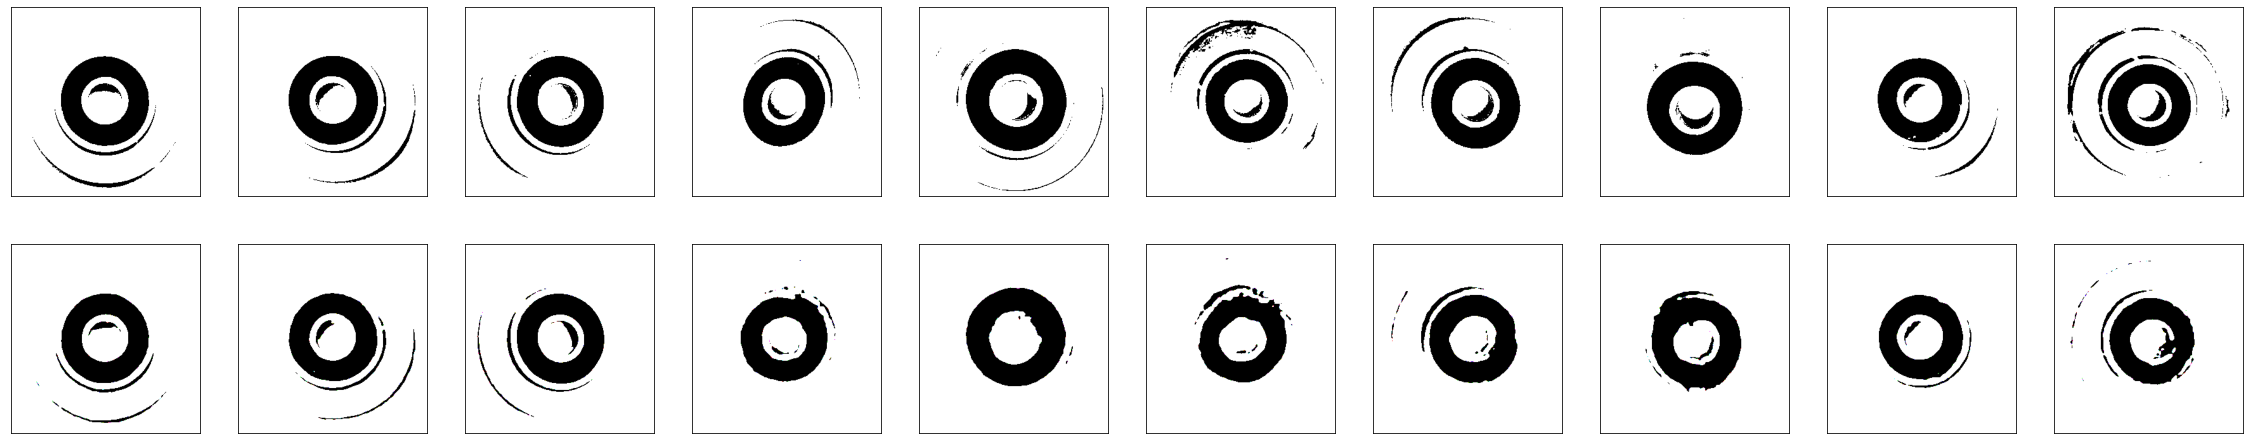

In [63]:
n = 10
plt.figure(figsize=(40, 8))
for i in range(n):

    # テスト画像を表示
    ax = plt.subplot(2, n, i+1)
    test_data_bi     = binary_image(test_data[i],0.2)
    
    plt.imshow(test_data_bi.reshape(300, 300, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換画像を表示
    ax = plt.subplot(2, n, i+1+n)
    pred_sub_data_bi = binary_image(pred_sub_data[i],0.2)
    plt.imshow(pred_sub_data_bi.reshape(300, 300, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [36]:
# SIGNATEテスト画像

pred_sub_data = model.predict(test_data)
print("pred_sub_data.shape",pred_sub_data.shape)

ok =0
pred_sub = []
for i in range(100):
    #２値化
    test_data_bi     = binary_image(test_data[i],0.5)
    pred_sub_data_bi = binary_image(pred_sub_data[i],0.5)
    #再構成誤差
    reconstruction_loss = binary_crossentropy(K.flatten(test_data_bi), K.flatten(pred_sub_data_bi))
    if reconstruction_loss <= 1.40:
        f_ok = 1
    else:
        f_ok = 0 
    pred_sub.append(f_ok)
    #print("f_ok=", f_ok)

#print(pred_sub)


pred_sub_data.shape (100, 300, 300, 3)
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1]


In [54]:
pred_df=pd.DataFrame(data=pred_sub)
test_list[1]=pred_df
test_list.head(10)

,0,1
0,19871.jpeg,1
1,29934.jpeg,1
2,39826.jpeg,1
3,49888.jpeg,0
4,59918.jpeg,0
5,69975.jpeg,0
6,79963.jpeg,0
7,89914.jpeg,0
8,99851.jpeg,0
9,109996.jpeg,0


In [38]:
test_list.to_csv(path +'vae_submission.csv', header=None, index=False)

In [52]:
#過去の提出ファイル(0.99)と比較
ans = pd.read_csv(path + 'sub_vit_tpu_chuzo.csv',header=None)
ans.head(10)

,0,1
0,19871.jpeg,1
1,29934.jpeg,1
2,39826.jpeg,1
3,49888.jpeg,0
4,59918.jpeg,1
5,69975.jpeg,0
6,79963.jpeg,0
7,89914.jpeg,0
8,99851.jpeg,1
9,109996.jpeg,0


In [41]:
#過去の提出ファイル(0.99)と比較
same = 0
for i in range(100):
  if ans.iloc[i , -1] == test_list.iloc[i, -1]:
    same += 1

print(same/100) 

0.8
